## 단일 에이전트로 Perplexity 만들어 보기

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

True

### WolframAlpha API 활용을 위한 비동기 설정

In [2]:
import asyncio

asyncio.set_event_loop_policy(asyncio.DefaultEventLoopPolicy())

import nest_asyncio

nest_asyncio.apply()

In [3]:
from langchain_community.utilities.wolfram_alpha import WolframAlphaAPIWrapper

wolfram = WolframAlphaAPIWrapper()

### State 설정

In [4]:
from typing import Annotated, Literal, TypedDict
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]
    focus: Literal["web", "academic", "video", "math"]

### 도구 정의  
웹검색, 논문검색, 수학계산

In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities import ArxivAPIWrapper
from langchain_community.tools import YouTubeSearchTool
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_community.utilities.wolfram_alpha import WolframAlphaAPIWrapper
import re

In [6]:
web_tool = TavilySearchResults(max_results=2)


@tool
def academic_tool(query: str):
    """
    academic paper search tool
    """
    arxiv = ArxivAPIWrapper()
    docs = arxiv.run(query)
    return docs


@tool
def math_tool(query: str):
    """
    math tool
    """
    wolfram = WolframAlphaAPIWrapper()
    result = wolfram.run(query)
    return result

/var/folders/l_/8kygc87n5q1d13jbjvmg1mdm0000gn/T/ipykernel_48220/1829567875.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  web_tool = TavilySearchResults(max_results=2)


In [7]:
academic_tool.run("AI 에이전트")

"Published: 2024-08-26\nTitle: AI Thinking: A framework for rethinking artificial intelligence in practice\nAuthors: Denis Newman-Griffis\nSummary: Artificial intelligence is transforming the way we work with information\nacross disciplines and practical contexts. A growing range of disciplines are\nnow involved in studying, developing, and assessing the use of AI in practice,\nbut these disciplines often employ conflicting understandings of what AI is and\nwhat is involved in its use. New, interdisciplinary approaches are needed to\nbridge competing conceptualisations of AI in practice and help shape the future\nof AI use. I propose a novel conceptual framework called AI Thinking, which\nmodels key decisions and considerations involved in AI use across disciplinary\nperspectives. The AI Thinking model addresses five practice-based competencies\ninvolved in applying AI in context: motivating AI use in information processes,\nformulating AI methods, assessing available tools and technol

In [8]:
# math_tool.run("123*123^2")

- 안됨, 추후 해볼것

비디오 검색도구

In [9]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.tools import YouTubeSearchTool
from langchain_community.document_loaders import YoutubeLoader
from langchain_core.documents import Document
import ast

youtube_search_tool = YouTubeSearchTool()


@tool
def video_tool(query: str) -> str:
    """
    Retriever tool for the transcript of a YouTube video.
    If user want to find some information, this tool is good to gather youtube video information.
    query should be given in string format.
    """
    # query에 해당하는 Youtube 비디오 URL 가져오기
    urls = youtube_search_tool.run(query)
    urls = ast.literal_eval(urls)
    # URL 순회하면서 Document 객체에 내용 담기
    docs = []
    for url in urls:
        loader = YoutubeLoader.from_youtube_url(
            url, add_video_info=True, language=["en", "ko"]
        )
        scripts = loader.load()
        script_content = scripts[0].page_content
        title = scripts[0].metadata["title"]
        author = scripts[0].metadata["author"]
        doc = Document(
            page_content=script_content,
            metadata={"source": url, "title": title, "author": author},
        )
        docs.append(doc)

    # 모든 비디오의 내용을 벡터DB에 담기
    text_splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", ".", ",", " ", ""], chunk_size=1000, chunk_overlap=0
    )
    texts = text_splitter.split_documents(docs)
    embeddings = OpenAIEmbeddings()
    db = Chroma.from_documents(texts, embeddings)
    retriever = db.as_retriever()
    retrieved_docs = retriever.invoke(query)

    video_results = []

    for doc in retrieved_docs:
        title = doc.metadata.get("title", "No title available")
        author = doc.metadata.get("author", "No author available")
        script_content = doc.page_content

        video_info = f"""
        Video Information:
        ------------------
        Title: {title}
        Author: {author}
        Transcript:
        {script_content}
        ------------------
        """
        video_results.append(video_info)

    # Join all video results into a single string
    all_video_results = "\n\n".join(video_results)

    return all_video_results

In [10]:
# video_tool.run("테디노트가 누구야?")

- 안됨 추후 할 것

### 각 도구를 개별 ToolNode로 설정

In [11]:
# tools = {
#     "web": [web_tool],
#     "academic": [academic_tool],
#     "video": [video_tool],
#     "math": [math_tool],
# }

tools = {
    "web": [web_tool],
    "academic": [academic_tool],
    "video": [],
    "math": [],
}

tool_nodes = {focus: ToolNode(tools[focus]) for focus in tools}

In [12]:
tool_nodes

{'web': tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'tavily_search_results_json': TavilySearchResults(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))}, tool_to_state_args={'tavily_search_results_json': {}}, tool_to_store_arg={'tavily_search_results_json': None}, handle_tool_errors=True, messages_key='messages'),
 'academic': tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'academic_tool': StructuredTool(name='academic_tool', description='academic paper search tool', args_schema=<class 'langchain_core.utils.pydantic.academic_tool'>, func=<function academic_tool at 0x13534b6a0>)}, tool_to_state_args={'academic_tool': {}}, tool_to_store_arg={'academic_tool': None}, handle_tool_errors=True, messages_key='messages'),
 'video': tools(tags=None, recurse=True, ex

### 챗봇 설정

In [13]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model = "gpt-4o-mini")

def chatbot(state: State):
    llm_with_tools = llm.bind_tools(tools[state["focus"]])
    result = llm_with_tools.invoke(state["messages"])
    return {"messages": [result]}

### 그래프 구축

In [14]:
from langgraph.graph import StateGraph, END

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

for focus, tool_node in tool_nodes.items():
    graph_builder.add_node(f"{focus}_tools", tool_node)


def focus_condition(state):
    if state["messages"][-1].tool_calls:
        return f"{state['focus']}_tools"
    return END  # END 상수 사용


graph_builder.add_conditional_edges(
    "chatbot",
    focus_condition,
    {
        "web_tools": "web_tools",
        "academic_tools": "academic_tools",
        "video_tools": "video_tools",
        "math_tools": "math_tools",
        END: END,
    },
)

for focus in tools:
    graph_builder.add_edge(f"{focus}_tools", "chatbot")

graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

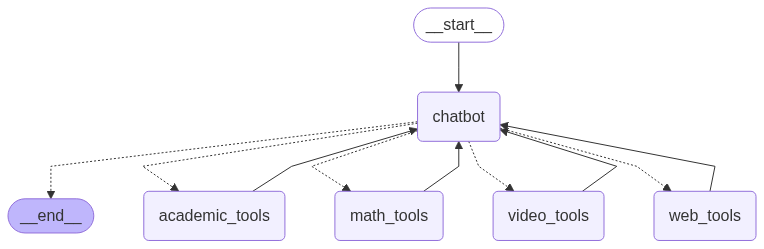

In [15]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
# example with a multiple tool calls in succession

for chunk in graph.stream(
    {
        "messages": [
            {"role": "user", "content": "AI 에이전트에는 어떤 프레임워크가 있어?"}
        ],
        "focus": "web",
    },
    stream_mode="values",
):
    print(chunk["messages"][-1].content)

AI 에이전트에는 어떤 프레임워크가 있어?

[{"title": "AI Agent의 개념과 기본 구현 방법 - 성장通", "url": "https://kevin-rain.tistory.com/226", "content": "이처럼 AI Agent는 단순한 답변을 넘어 다단계 의사결정을 수행할 수 있도록 발전하고 있다. LangGraph, LangChain, LlamaIndex와 같은 프레임워크를 활용하면 복잡한 논리 흐름을 쉽게 구현할 수 있으며, 이를 통해 보다 정교한 AI Agent를 개발할 수 있다. 앞으로 AI Agent는 다양한 도구와 결합하여 더욱 강력한 성능을 발휘할 것이다. [...] AI Agent의 개념과 기본 구현 방법\n\nAI Agent의 개념과 기본 구현 방법\n\nAI Agent는 특정한 목적을 달성하기 위해 설계된 인공지능 시스템으로, 외부 환경과 상호작용하며 데이터를 기반으로 결정을 내린다. 최근에는 다양한 AI Agent 프레임워크가 등장하면서, 이를 활용한 개발이 점점 쉬워지고 있다. 하지만 AI Agent의 핵심 개념을 이해하는 것이 중요하며, 이를 직접 구현해보는 과정이 큰 도움이 된다.\n\n이번 글에서는 Dummy Agent를 구현해서 그 동작 과정을 살펴보도록 하겠다.\n\nHugging Face Serverless API 활용\n\nHugging Face는 AI 모델을 실행할 수 있는 Serverless API를 제공한다. 이를 이용하면 로컬 환경에서 직접 모델을 실행하지 않고도 Inference를 수행할 수 있다. API 호출을 위해 적절한 클라이언트를 활용하면, 이를 통해 텍스트 생성이나 명령 실행을 수행할 수 있다. [...] 이러한 방식을 이용하면 AI 모델이 텍스트를 생성하여 출력하는 것을 확인할 수 있다.\n\n일반적인 경우, chat template을 사용하지만, 여기서는 text_generation을 기준으로 작성하겠다.\n\nAgent의 동작 방식\n\nAI Agent는 특정한 입력을 받아 문제를 해